In [36]:
import pywt
import numpy as np
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

%matplotlib inline

# Model Implementation

### Layers

In [37]:
class dwt:
    def __init__(self, filter_size, h = None, g = None):
        if h is None:
            self.h = np.random.normal(1,2,filter_size)
        else:
            self.h = h
        
        if g is None:
            self.g = np.random.normal(1,2,filter_size)
        else:
            self.g = g
        
    def compute(self, input_):
        filter_bank = [self.h, self.g, np.flip(self.h), np.flip(self.g)]
        my_wavelet = pywt.Wavelet(name="my_wavelet", filter_bank=filter_bank)
        return pywt.dwt(input_, wavelet=my_wavelet)
    
    def inverse(self):
        return idwt(self)
    
    def update_weigths(self, hg, gg, lr = 0.001):
        self.h = self.h - lr*hg
        self.g = self.g - lr*gg

In [38]:
class idwt:
    def __init__(self, dwt):
        self.h = dwt.h
        self.g = dwt.g
    
    def compute(self, input_):
        ca,cd = input_
        filter_bank = [self.h, self.g, np.flip(self.h), np.flip(self.g)]
        my_wavelet = pywt.Wavelet(name="my_wavelet", filter_bank=filter_bank)
        return pywt.idwt(ca,cd, wavelet=my_wavelet)

### Loss function

In [39]:
def loss_function(h, g, x, x_, W, reconstruction_weight = 1):
    l1 = 0.5
    l2 = 0.5
    r1 = reconstruction_weight
    s1 = mean_squared_error(x, x_)
    s2 = np.sum(np.abs(W))
    s3 = lhg(h,g)
    return r1*s1 + l1*s2 + l1*s3
    
def lhg(h, g):
    s1 = (np.sum(h**2) - 1)**2
    s2 = (np.sum(h) - math.sqrt(2))**2
    s3 = np.sum(g)**2
    return s1 + s2 + s3

### Gradient Computation

In [40]:
def compute_gradient_h(h, g, x, loss_function, diff = 0.001):
    length = len(h)
    gradient = np.zeros(length)
    mask = np.zeros(length)
    for i in range(length):
        mask[i] = diff
        h_plus = h + mask
        h_minus = h - mask
        
        dwtp = dwt(1, h_plus, g)
        idwtp = dwtp.inverse()
        
        dwtm = dwt(1, h_minus, g)
        idwtm = dwtm.inverse()
        
        Wp = dwtp.compute(x)
        x_p = idwtp.compute(Wp)
        
        Wm = dwtm.compute(x)
        x_m = idwtm.compute(Wm)
        
        mask[i] = 0
        
        lossp = loss_function(h_plus, g, x, x_p, Wp)
        lossm = loss_function(h_minus, g, x, x_m, Wm)
        gradient[i] = (lossp - lossm)/(2*diff)
        
    return gradient

def compute_gradient_g(h, g, x, loss_function, diff = 0.001):
    length = len(g)
    gradient = np.zeros(length)
    mask = np.zeros(length)
    for i in range(length):
        mask[i] = diff
        g_plus = g + mask
        g_minus = g - mask
        
        dwtp = dwt(1, h, g_plus)
        idwtp = dwtp.inverse()
        
        dwtm = dwt(1, h, g_minus)
        idwtm = dwtm.inverse()
        
        Wp = dwtp.compute(x)
        x_p = idwtp.compute(Wp)
        
        Wm = dwtm.compute(x)
        x_m = idwtm.compute(Wm)
        
        mask[i] = 0
        
        lossp = loss_function(h, g_plus, x, x_p, Wp)
        lossm = loss_function(h, g_minus, x, x_m, Wm)
        gradient[i] = (lossp - lossm)/(2*diff)
        
    return gradient

def compute_gradient(h, g, x, loss_function, diff = 0.001):
    hg = compute_gradient_h(h, g, x, loss_function, diff)
    gg = compute_gradient_g(h, g, x, loss_function, diff)
    return (hg, gg)
    
    
    

### Model Class

In [41]:
class Model:
    def __init__(self,filter_size = 2**5):
        self.my_dwt = dwt(filter_size)
        self.my_idwt = self.my_dwt.inverse()
        self.losses = []
        self.min_loss = math.inf
        
    def fit(self, x, epochs = 100, learning_rate = 0.001, verbose = True, good_error = None, reconstruction_weight = 1, diff = 0.000001):
        best_h = self.my_dwt.h
        best_g = self.my_idwt.g
        for i in range(epochs):
            W = self.my_dwt.compute(x)
            x_ = self.my_idwt.compute(W)
            loss = loss_function(self.my_dwt.h, self.my_dwt.g, x, x_, W, reconstruction_weight)
            self.losses.append(loss)
            if loss < self.min_loss:
                self.min_loss = loss
                best_h = self.my_dwt.h
                best_g = self.my_dwt.g
            
            if verbose:
                print('Epochs #' + str(i+1) + ": " + str(loss) + " loss")
            
            if not good_error is None and loss <= good_error:
                return
            
            hg, gg = compute_gradient(self.my_dwt.h, self.my_dwt.g, x, loss_function, diff)
            self.my_dwt.update_weigths(hg, gg, learning_rate)
        
        self.my_dwt = dwt(1, best_h, best_g)
        self.my_idwt = self.my_dwt.inverse()
        print("Best Loss", self.min_loss)
    
    def predict(self, x):
        W = self.my_dwt.compute(x)
        return self.my_idwt.compute(W)
    
    def wavelet(self):
        filter_bank = [self.my_dwt.h, self.my_dwt.g, np.flip(self.my_dwt.h), np.flip(self.my_dwt.g)]
        my_wavelet = pywt.Wavelet(name="my_wavelet", filter_bank=filter_bank)
        return my_wavelet
    
    def dwt(self, x):
        ca, cd = self.my_dwt.compute(x)
        return np.concatenate([cd, ca])
    
        
            

# Testing

### Signal generation functions

In [42]:
def generate_wave_coeff(length):
    result = []
    for _ in range(length*2):
        if np.random.random() < 0.9:
            result.append(0.0)
        else:
            result.append(np.random.uniform(-1,1))
    
    return (result[:length], result[length:])


def generate_signal(length, familie):    
    ca, cd = generate_wave_coeff(length)
    x = pywt.idwt(ca, cd, familie)
    return x


### Distance between filters

In [43]:
def dist(f1, f2):
    max_l = max(len(f1), len(f2))
    min_l = min(len(f1), len(f2))
    diff = max_l - min_l
    best_i = 0
    
    if len(f1) == min_l:
        f1 = np.concatenate([f1, np.zeros(diff)])
        
    if len(f2) == min_l:
        f2 = np.concatenate([f2, np.zeros(diff)])
    
    distance = math.inf
    f1_norm2 = np.sqrt(np.sum(f1**2))
    f2_norm2 = np.sqrt(np.sum(f2**2))
    for i in range(max_l):
        current = 1 - (f1.dot(np.roll(f2,i))/(f1_norm2 * f2_norm2))
        if current < distance:
            distance = current
            best_i = i
    
    f2 = np.roll(f2, best_i)
    return distance

### Currently the built-in families are:

   - Haar (haar)
   - Daubechies (db)
   - Symlets (sym)
   - Coiflets (coif)
   - Biorthogonal (bior)
   - Reverse biorthogonal (rbio)
   - “Discrete” FIR approximation of Meyer wavelet (dmey)
   - Gaussian wavelets (gaus)
   - Mexican hat wavelet (mexh)
   - Morlet wavelet (morl)
   - Complex Gaussian wavelets (cgau)
   - Shannon wavelets (shan)
   - Frequency B-Spline wavelets (fbsp)
   - Complex Morlet wavelets (cmor)


### Print wavelets for a familie

In [64]:
print(pywt.wavelist('haar'))

['haar']


### Select a orthogonal wavelet for testing

In [77]:
w = 'haar'
wavelet = pywt.Wavelet(w)
print("is orthogonal?",wavelet.orthogonal)
wavelet.dec_len

is orthogonal? True


2

### Signal generation and fiting

In [78]:
x = generate_signal(32, w)

In [84]:

model = Model(2)

In [85]:
model.fit(x, epochs=2000, learning_rate=0.001, good_error=4, reconstruction_weight=10)

Epochs #1: 25.46784799134455 loss
Epochs #2: 25.232892477115573 loss
Epochs #3: 25.004798846902553 loss
Epochs #4: 24.7832287261005 loss
Epochs #5: 24.56786527419964 loss
Epochs #6: 24.358411543139624 loss
Epochs #7: 24.15458898059306 loss
Epochs #8: 23.956136063750723 loss
Epochs #9: 23.76280705030088 loss
Epochs #10: 23.5743708358968 loss
Epochs #11: 23.39060990703903 loss
Epochs #12: 23.21131938117187 loss
Epochs #13: 23.03630612506776 loss
Epochs #14: 22.865387944672715 loss
Epochs #15: 22.698392839740006 loss
Epochs #16: 22.53515831728553 loss
Epochs #17: 22.37553075885955 loss
Epochs #18: 22.219364836395705 loss
Epochs #19: 22.066522972946466 loss
Epochs #20: 21.91687484404055 loss
Epochs #21: 21.77029691621472 loss
Epochs #22: 21.626672019846694 loss
Epochs #23: 21.48588895295555 loss
Epochs #24: 21.347842113874435 loss
Epochs #25: 21.212431160007796 loss
Epochs #26: 21.079560690897118 loss
Epochs #27: 20.949139953436916 loss
Epochs #28: 20.821082567606044 loss
Epochs #29: 20.69

Epochs #251: 8.84624544344939 loss
Epochs #252: 8.82097097171754 loss
Epochs #253: 8.790600320198097 loss
Epochs #254: 8.765254390932544 loss
Epochs #255: 8.73536209029097 loss
Epochs #256: 8.70994569919377 loss
Epochs #257: 8.68052564878029 loss
Epochs #258: 8.655135398066427 loss
Epochs #259: 8.632725792031188 loss
Epochs #260: 8.600884695228375 loss
Epochs #261: 8.578416078259885 loss
Epochs #262: 8.547023470347638 loss
Epochs #263: 8.524496890481142 loss
Epochs #264: 8.493546933254876 loss
Epochs #265: 8.470963425348211 loss
Epochs #266: 8.44045037896765 loss
Epochs #267: 8.417810964596466 loss
Epochs #268: 8.387729185430747 loss
Epochs #269: 8.365034872870401 loss
Epochs #270: 8.335378811384206 loss
Epochs #271: 8.312630595568018 loss
Epochs #272: 8.283394794291063 loss
Epochs #273: 8.260593656788844 loss
Epochs #274: 8.231772748332116 loss
Epochs #275: 8.208919657348574 loss
Epochs #276: 8.180508362465837 loss
Epochs #277: 8.157604272823857 loss
Epochs #278: 8.129597398586462 los

Epochs #487: 4.1881737345282115 loss
Epochs #488: 4.17145755920962 loss
Epochs #489: 4.159693336066135 loss
Epochs #490: 4.143055694605772 loss
Epochs #491: 4.131341588348703 loss
Epochs #492: 4.114781240591164 loss
Epochs #493: 4.103117618954187 loss
Epochs #494: 4.0866333437175255 loss
Epochs #495: 4.075020571671049 loss
Epochs #496: 4.058611166598677 loss
Epochs #497: 4.047049606408758 loss
Epochs #498: 4.0307138878337945 loss
Epochs #499: 4.0192038991261905 loss
Epochs #500: 4.002940701919899 loss
Epochs #501: 3.991482641726522 loss


## Metrics and plot

 ### Reconstruction Error

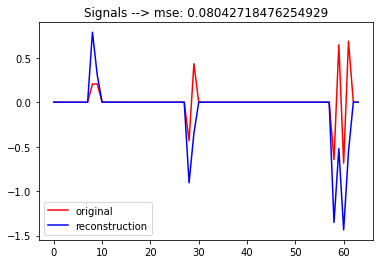

In [86]:
p = model.predict(x)
mse = mean_squared_error(p,x)

plt.plot(np.arange(len(x)), x, c = 'r', label="original")
plt.plot(np.arange(len(p)), p, c = 'b', label="reconstruction")
plt.legend()
plt.title("Signals -->" + " mse: " + str(mse))
print()

### Wavelets and Scaling functions error

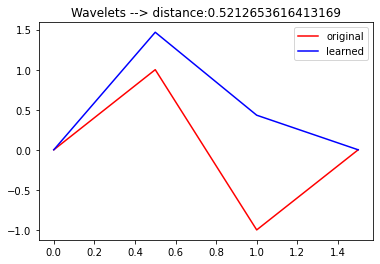

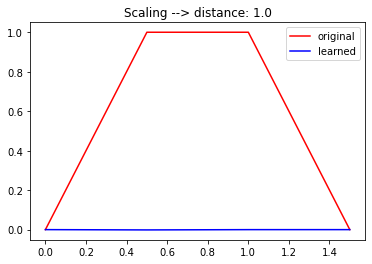

In [87]:
[phi_d,psi_d,phi_r,psi_r,al] = model.wavelet().wavefun(level=1)
[phi, psi, ao] = pywt.Wavelet(w).wavefun(level=1)
lo = np.arange(len(ao))
plt.figure(1)
plt.plot(ao, psi, c = 'r', label="original")
plt.plot(al,psi_d, c='b', label='learned')
plt.title("Wavelets --> distance:" + str(dist(psi, psi_d)))
plt.legend()

plt.figure(2)
plt.title("Scaling --> distance: " +  str(dist(phi, phi_d)))
plt.plot(ao, phi, c = 'r', label="original")
plt.plot(al,phi_d, c='b', label='learned')
plt.legend()


print()

### DWT error

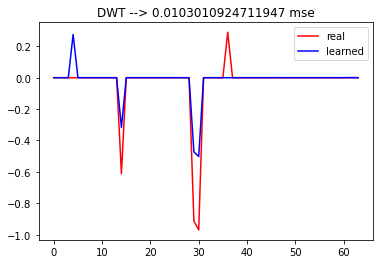

In [88]:

fake_dwt = model.dwt(x)
ca, cd = pywt.dwt(x, wavelet=w)
real_dwt = np.concatenate([cd, ca])

fake_len = len(fake_dwt)
real_len = len(real_dwt)

min_len = min(fake_len, real_len)
real_dwt = real_dwt[:min_len]
fake_dwt = fake_dwt[:min_len]

mse_dwt = mean_squared_error(real_dwt, fake_dwt)
plt.plot(np.arange(min_len), real_dwt, c = 'r', label = 'real')
plt.plot(np.arange(min_len), fake_dwt, c = 'b', label = 'learned')
plt.title("DWT --> " + str(mse_dwt) + " mse")
plt.legend()
print()